In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import torch
import os
import matplotlib.pyplot as plt

from torchvision import transforms

import torch
import argparse
import os
import cv2
from PIL import Image
from IPython.display import display


# CONFIG

In [ ]:
ALL_CLASSES = ['background', 'flood']

LABEL_COLORS_LIST = [
    (0, 0, 0), # Background.
    (255, 255, 255), # Flood.
]

VIS_LABEL_MAP = [
    (0, 0, 0), # Background.
    (255, 0, 0), # Flood.
]

# MODEL

In [ ]:
import torch.nn as nn

#from torchvision.models.segmentation import deeplabv3_resnet50

#def prepare_model(num_classes=2):
#    model = deeplabv3_resnet50(weights='DEFAULT')
#    model.classifier[4] = nn.Conv2d(256, num_classes, 1)
#    model.aux_classifier[4] = nn.Conv2d(256, num_classes, 1)
#    return model


"""
Uncomment the following lines to train on the DeepLabV3 ResNet101 model.
"""

from torchvision.models.segmentation import deeplabv3_resnet101

def prepare_model(num_classes=2):
    model = deeplabv3_resnet101(weights='DEFAULT')
    model.classifier[4] = nn.Conv2d(256, num_classes, 1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, 1)
    return model

# UTILS

In [ ]:
plt.style.use('ggplot')

def set_class_values(all_classes, classes_to_train):
    """
    This (`class_values`) assigns a specific class label to the each of the classes.
    For example, `animal=0`, `archway=1`, and so on.

    :param all_classes: List containing all class names.
    :param classes_to_train: List containing class names to train.
    """
    class_values = [all_classes.index(cls.lower()) for cls in classes_to_train]
    return class_values

def get_label_mask(mask, class_values, label_colors_list):
    """
    This function encodes the pixels belonging to the same class
    in the image into the same label

    :param mask: NumPy array, segmentation mask.
    :param class_values: List containing class values, e.g car=0, bus=1.
    :param label_colors_list: List containing RGB color value for each class.
    """
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for value in class_values:
        for ii, label in enumerate(label_colors_list):
            if value == label_colors_list.index(label):
                label = np.array(label)
                label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = value
    label_mask = label_mask.astype(int)
    return label_mask

def draw_translucent_seg_maps(
    data,
    output,
    epoch,
    i,
    val_seg_dir,
    label_colors_list,
):
    """
    This function color codes the segmentation maps that are generated while
    validating. THIS IS NOT TO BE CALLED FOR SINGLE IMAGE TESTING
    """
    alpha = 1  # how much transparency
    beta = 0.6  # alpha + beta should be 1
    gamma = 0  # contrast

    seg_map = output[0]  # use only one output from the batch
    seg_map = torch.argmax(seg_map.squeeze(), dim=0).detach().cpu().numpy()

    image = data[0]
    image = np.array(image.cpu())
    image = np.transpose(image, (1, 2, 0))

    red_map = np.zeros_like(seg_map).astype(np.uint8)
    green_map = np.zeros_like(seg_map).astype(np.uint8)
    blue_map = np.zeros_like(seg_map).astype(np.uint8)

    for label_num in range(0, len(label_colors_list)):
        index = seg_map == label_num
        red_map[index] = label_colors_list[label_num][0]
        green_map[index] = label_colors_list[label_num][1]
        blue_map[index] = label_colors_list[label_num][2]

    rgb = np.stack([red_map, green_map, blue_map], axis=2)
    rgb = np.array(rgb, dtype=np.float32)
    # convert color to BGR format for OpenCV
    rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, rgb, beta, gamma, image)
    cv2.imwrite(f"{val_seg_dir}/e{epoch}_b{i}.jpg", image)


class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss, epoch, model, out_dir, name='model'
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, os.path.join(out_dir, 'best_'+name+'.pth'))

def save_model(epochs, model, optimizer, criterion, out_dir, name='model'):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, os.path.join(out_dir, name+'.pth'))

def save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'accuracy.png'))

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'loss.png'))

# Define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def get_segment_labels(image, model, device):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image)
    return outputs

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()

    # create Numpy arrays containing zeros
    # later to be used to fill them with respective red, green, and blue pixels
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(VIS_LABEL_MAP)):
        index = labels == label_num
        red_map[index] = np.array(VIS_LABEL_MAP)[label_num, 0]
        green_map[index] = np.array(VIS_LABEL_MAP)[label_num, 1]
        blue_map[index] = np.array(VIS_LABEL_MAP)[label_num, 2]

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

def image_overlay(image, segmented_image):
    alpha = 1 # transparency for the original image
    beta = 1.0 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    return image

# IMAGE INFERENCE

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:03<00:00, 71.0MB/s]


Image 1


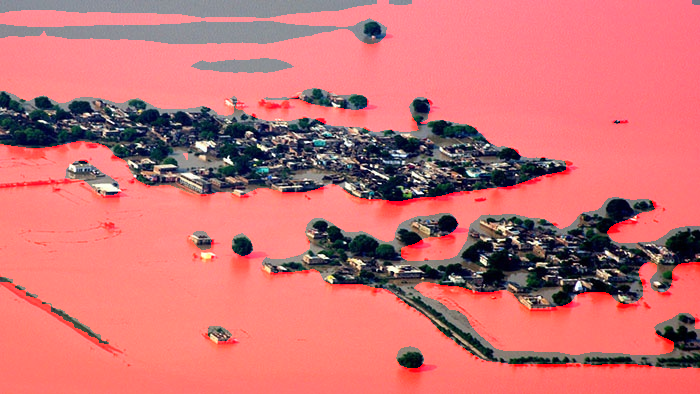

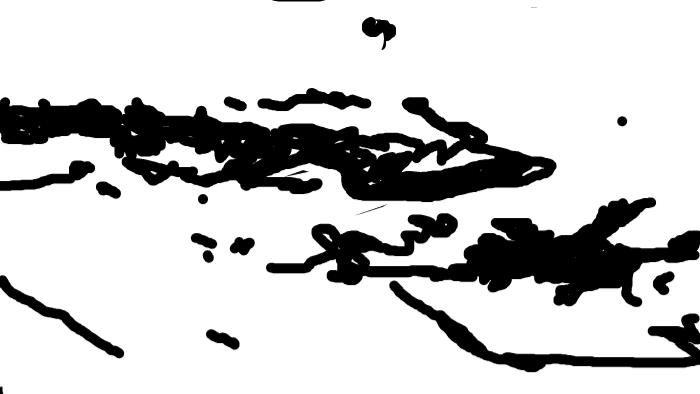

Image 2


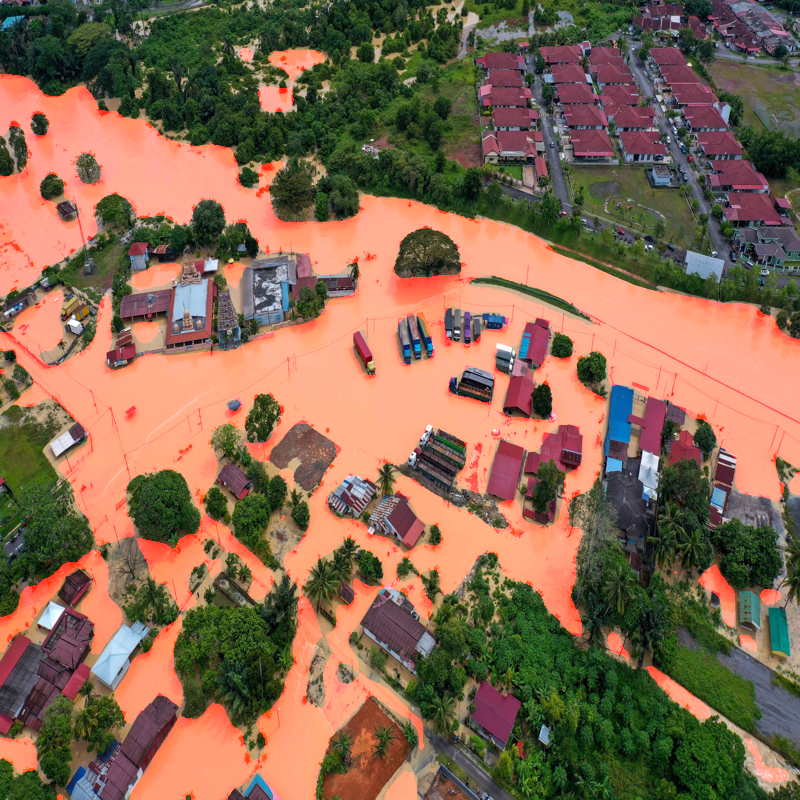

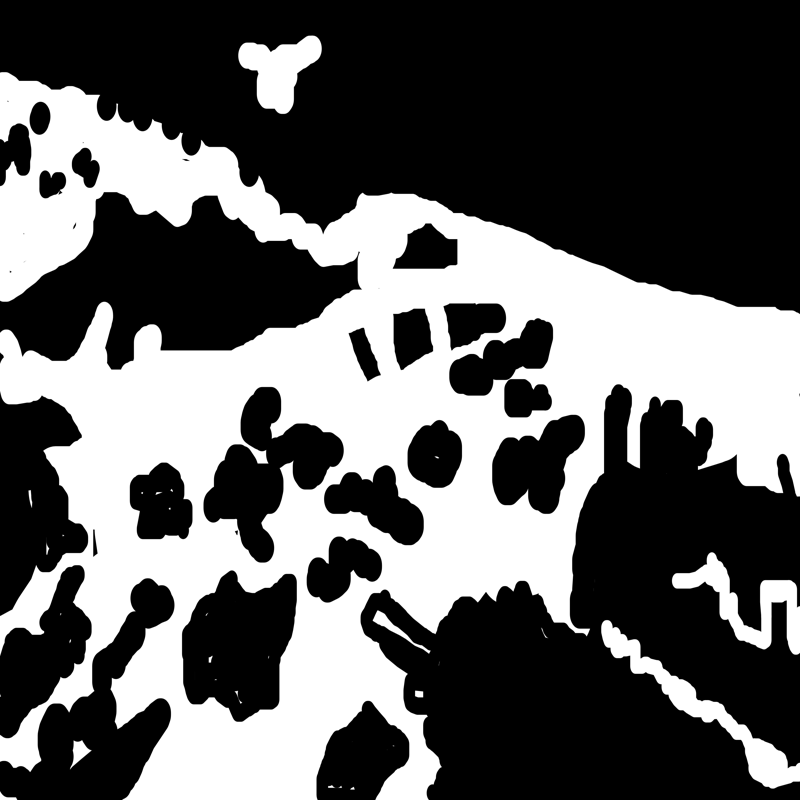

Image 3


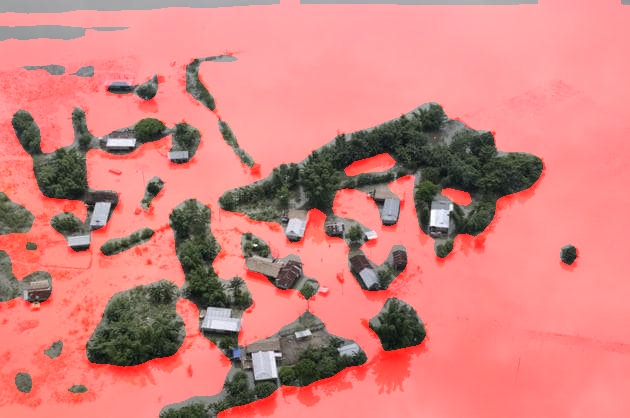

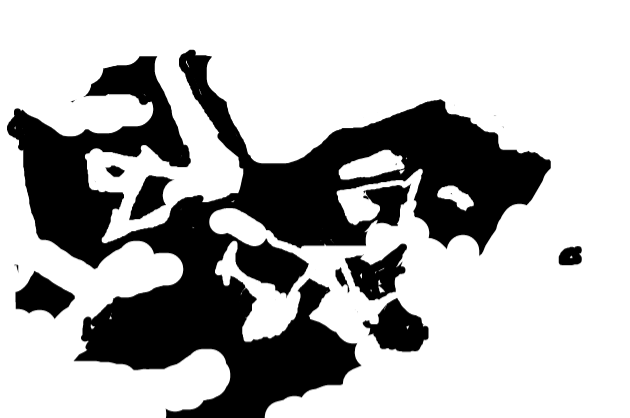

Image 4


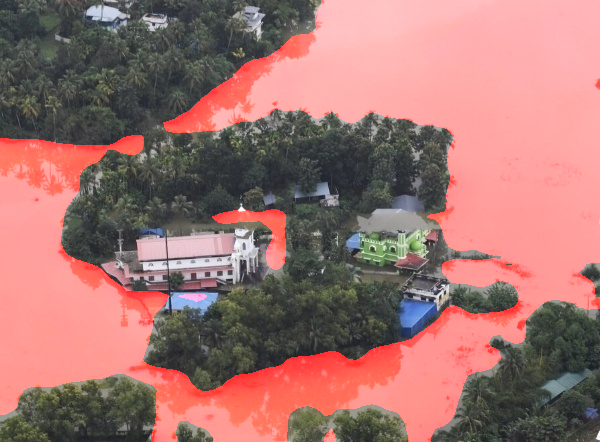

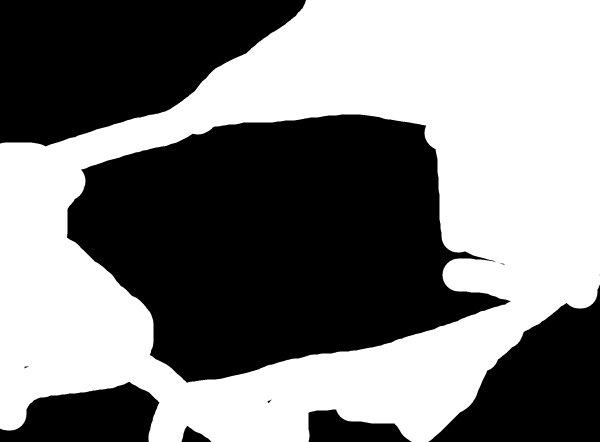

Image 5


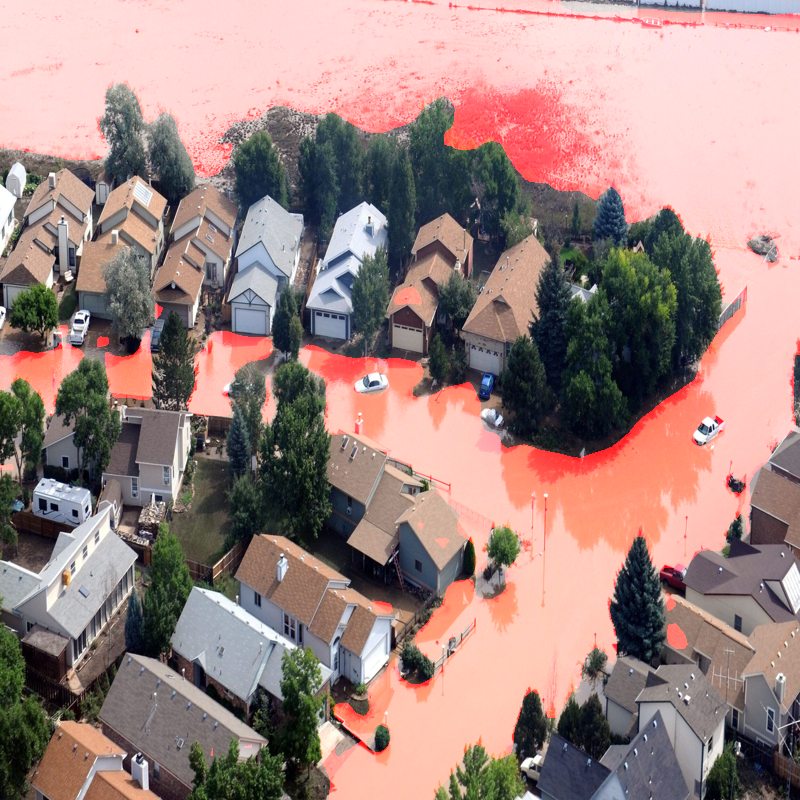

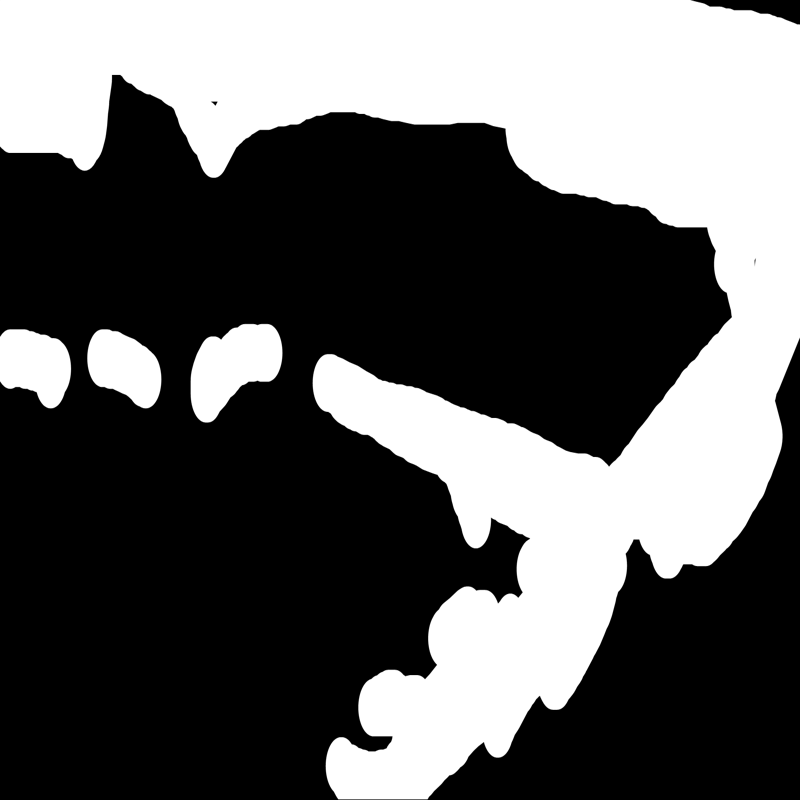

Image 6


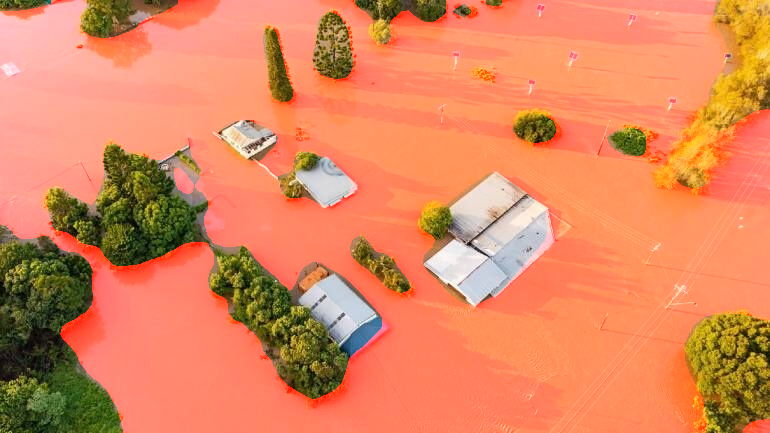

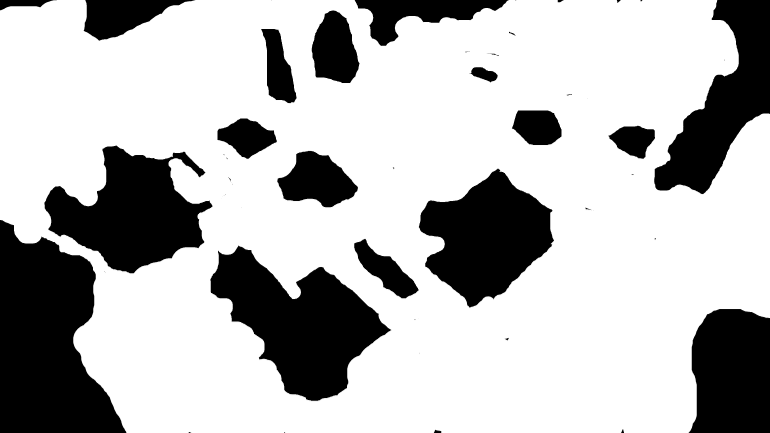

Image 7


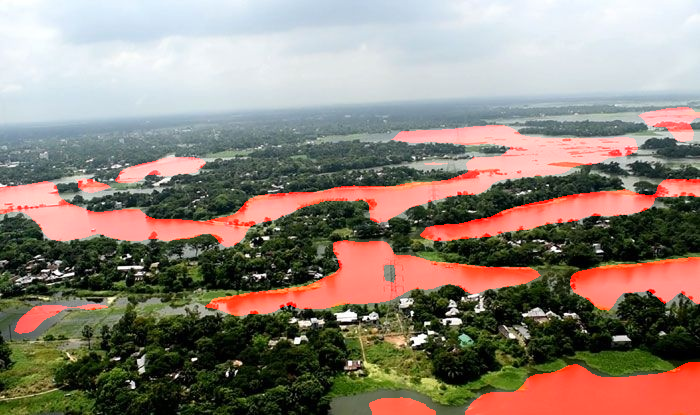

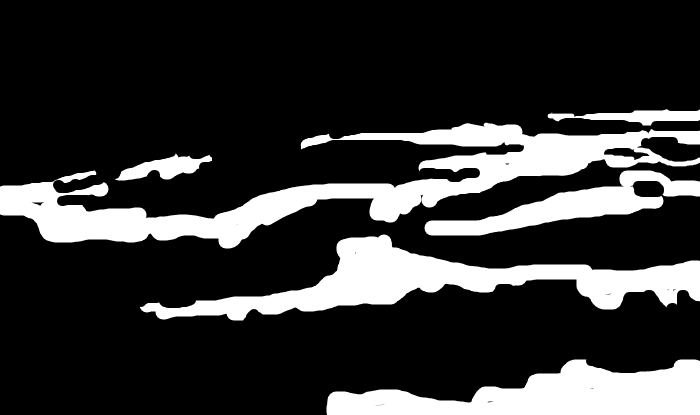

Image 8


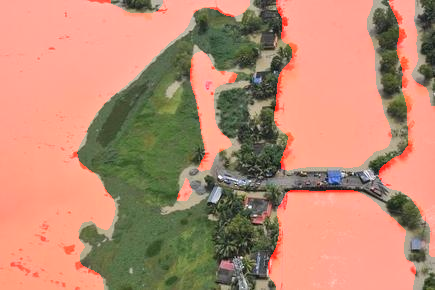

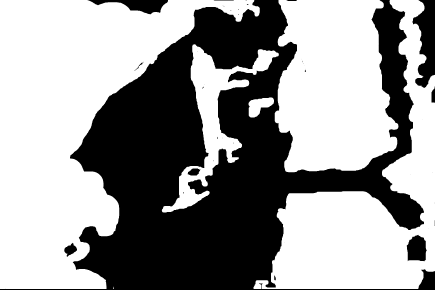

Image 9


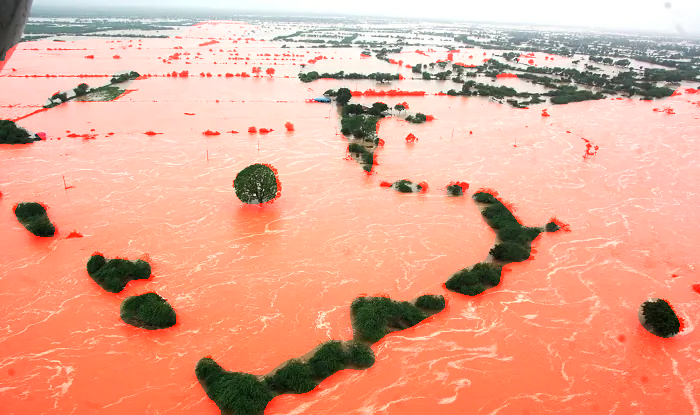

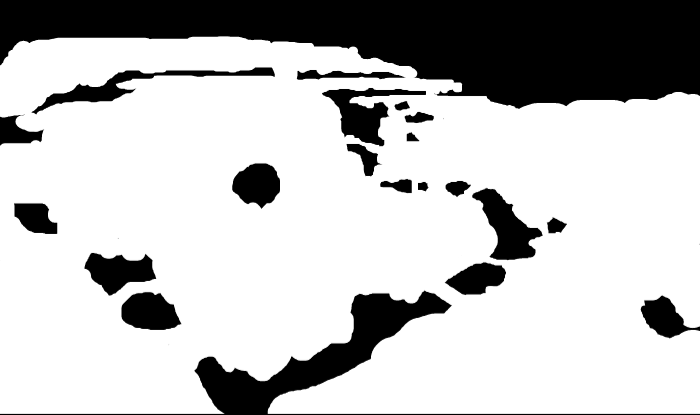

Image 10


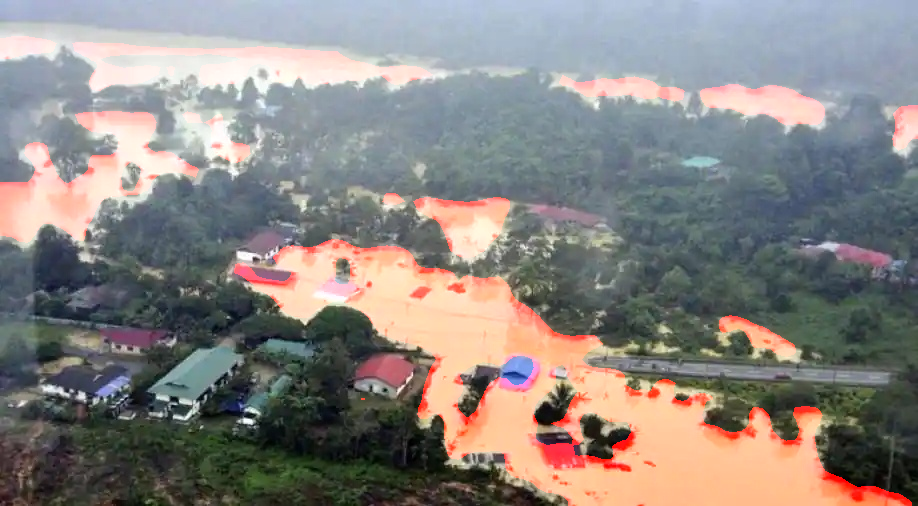

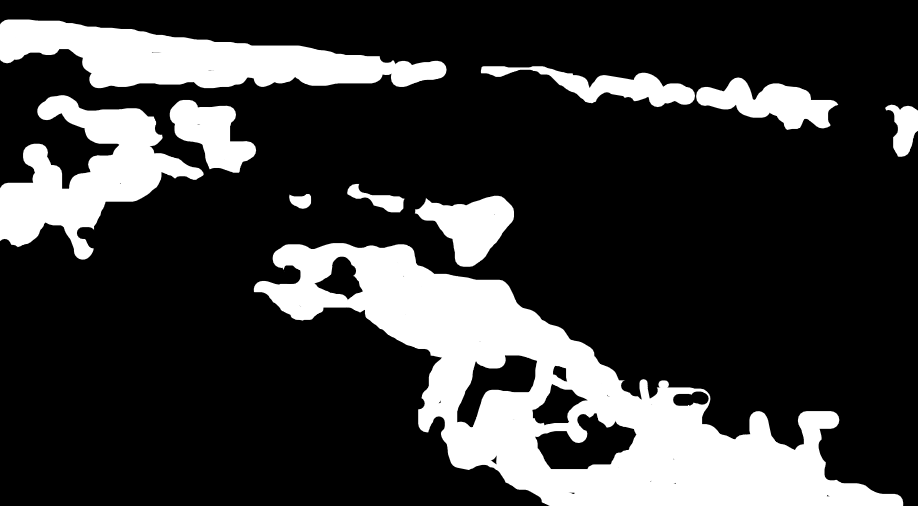

In [ ]:
import os
import torch
from PIL import Image
import cv2
import random
from google.colab.patches import cv2_imshow
from torchvision import transforms

# Define the input directory (change this to your desired path).
input_dir = '/content/drive/MyDrive/flood-area-segmentation/valid_images'

# Define the ground truth directory (change this to your ground truth mask path).
gt_dir = '/content/drive/MyDrive/flood-area-segmentation/valid_masks'

# Create the output directory.
out_dir = '/content/drive/MyDrive/flood-area-segmentation/outputs/inference_image_results'
os.makedirs(out_dir, exist_ok=True)

# Set computation device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming ALL_CLASSES and other functions are defined somewhere

# Assuming prepare_model, get_segment_labels, draw_segmentation_map, and image_overlay functions are defined

# Load the model
model = prepare_model(len(ALL_CLASSES))
ckpt = torch.load('/content/drive/MyDrive/flood-area-segmentation/outputs/best_DeepLabV3_ResNet101.pth', map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval().to(device)

# Get a list of all image paths in the input directory.
all_image_paths = os.listdir(input_dir)
random.shuffle(all_image_paths)
selected_image_paths = all_image_paths[:10]

for i, image_path in enumerate(selected_image_paths):
    print(f"Image {i+1}")

    # Read the image.
    image = Image.open(os.path.join(input_dir, image_path))

    # Read the ground truth mask.
    gt_mask_path = os.path.join(gt_dir, image_path.replace('.jpg', '.png'))
    gt_mask = Image.open(gt_mask_path)

    # Resize very large images (if width > 1024.) to avoid OOM on GPUs.
    if image.size[0] > 1024:
        image = image.resize((800, 800))
        gt_mask = gt_mask.resize((800, 800))

    # Do forward pass and get the output dictionary.
    outputs = get_segment_labels(image, model, device)

    # Get the data from the `out` key.
    outputs = outputs['out']
    segmented_image = draw_segmentation_map(outputs)

    final_image = image_overlay(image, segmented_image)

    # Display the image and ground truth mask in Colab.
    cv2_imshow(final_image)
    gt_mask_np = np.array(gt_mask)
    cv2_imshow(gt_mask_np)


    # Save the image.
    cv2.imwrite(os.path.join(out_dir, image_path), final_image)
